<a href="https://colab.research.google.com/github/nikas-belogolov/plant-disease-identification-ML/blob/master/Plant_disease_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Plant disease identification

## Introduction

This project aims to develop a neural network-based image classifier to identify diseases in pepper and potato plants. Leveraging deep learning techniques, the model will be trained to distinguish between healthy plants and those affected by various diseases. This application is crucial for early disease detection and effective crop management, potentially leading to higher yields and reduced losses.

### Goals

1. Identify Diseases: Develop a robust model capable of identifying diseases in pepper and potato plants from images.
2. Learn Image Identification with Neural Networks: Understand the process of building, training, and evaluating an image classification model using neural networks.
3. Understand and Use SHAP Values: Learn what SHAP (SHapley Additive exPlanations) values are and how to use them for model interpretability.

### Dataset

For this project I've used the [PlantVillage Dataset](https://www.kaggle.com/datasets/emmarex/plantdisease) from Kaggle.

The dataset contains images of pepper, tomato and potato plants categorized into different classes, including healthy plants and various disease conditions.

The dataset was truncated to 5 classes for simplicity (2 classes for pepper plants and 3 for potato plants), and split into training, validation, and test sets to ensure the model's robustness and generalizability.

## Setup

In [ ]:
!pip install tensorflow numpy seaborn scikit-learn pandas pathlib matplotlib shap PIL

In [ ]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
import pandas as pd
import shap
from PIL import Image
import random

from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
  from google.colab import drive
  drive.mount('/content/drive')
  dir = "/content/drive/MyDrive/PlantVillage_Dataset"
  split_dir = dir + "/split"
  models_dir = dir + "/models"
else:
  dir = "C:\\Users\\belog\\Documents\\PlantVillage_Dataset"
  split_dir = dir + "\\split"
  models_dir = dir + "\\models"

CLASSES = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
IMG_SIZE = (128, 128)
EPOCHS = 100
LEARNING_RATE = 0.0001
EARLY_STOPPING_PATIENCE = 5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train Test Validation Split

In [ ]:
#הגדרת תיקיות המקור והיעד של הפיצול.
source_dir = "/content/drive/MyDrive/PlantVillage_Dataset"
destination_dir = "/content/drive/MyDrive/PlantVillage_Dataset/split"

#הגדרת התיקיות החדשות בתיקיית היעד והמחלקות השונות
new_folders = ['train', 'test', 'val']
classes = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

for folder in new_folders:
    for class_name in classes:
        new_folder_path = os.path.join(destination_dir, folder, class_name)
        Path(new_folder_path).mkdir(parents=True, exist_ok=True)

def split_and_copy_files(source_dir, destination_dir, split_ratios):
    for class_name in classes:
        class_files = os.listdir(os.path.join(source_dir, class_name))
        random.shuffle(class_files)

        num_files = len(class_files)
        train_split = int(num_files * split_ratios[0])
        test_split = int(num_files * split_ratios[1])

        for i, file_name in enumerate(class_files):
            if i < train_split:
                dest_folder = os.path.join(destination_dir, 'train', class_name)
            elif i < train_split + test_split:
                dest_folder = os.path.join(destination_dir, 'test', class_name)
            else:
                dest_folder = os.path.join(destination_dir, 'val', class_name)

            shutil.copy(os.path.join(source_dir, class_name, file_name), dest_folder)
#מימדי הפיצול כמתואר בתא הטקסט מעל תא הקוד
split_ratios = [0.75, 0.15, 0.10]

split_and_copy_files(source_dir, destination_dir, split_ratios)

print("Files copied successfully!")

## Explore Dataset

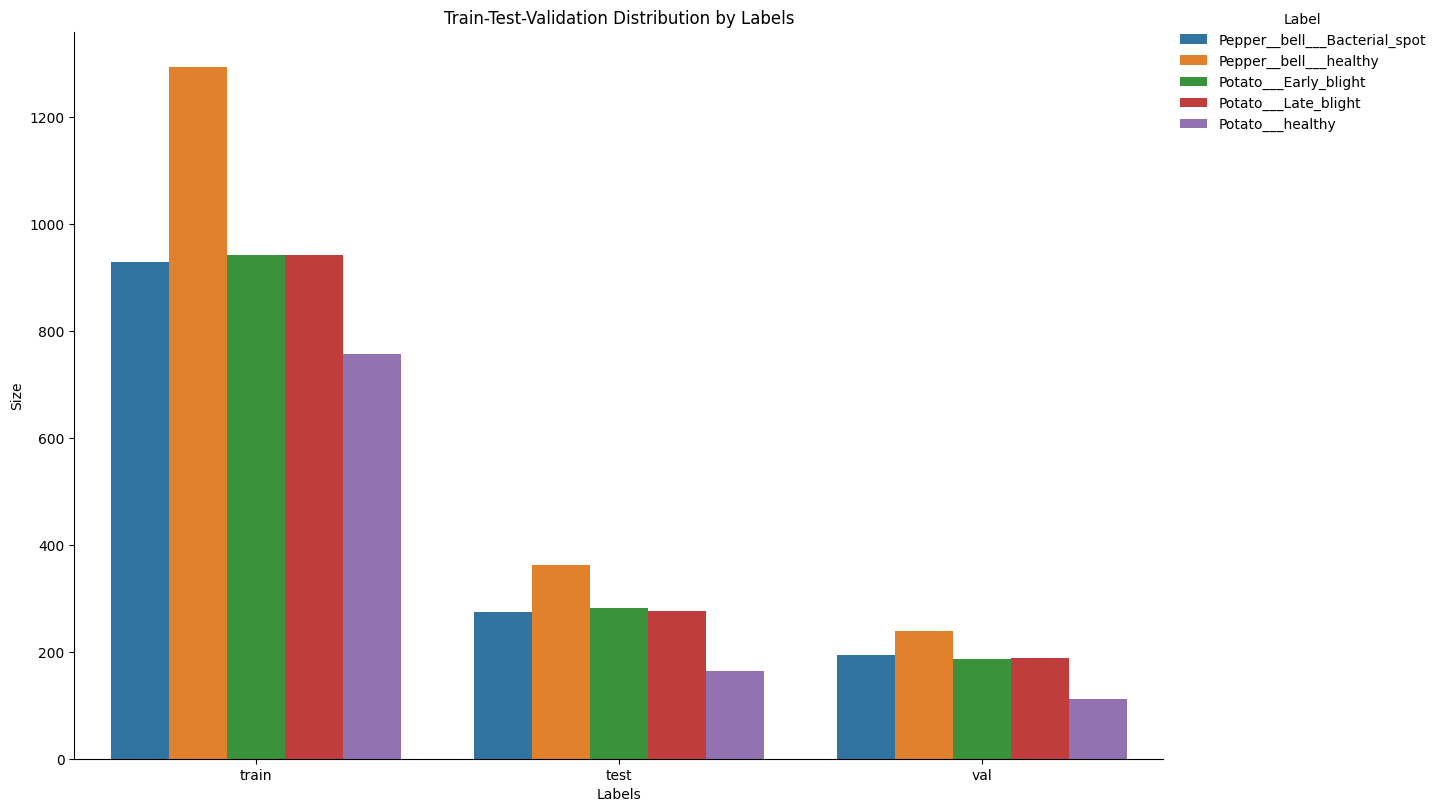

In [ ]:
classes = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Sample data (replace this with your actual data)
data = {
    'Label': classes * 3,
    'Split': [],
    'Size': []
}

for split_folder in os.listdir(split_dir):
  for i in range(0,5):
    data["Split"].append(split_folder)
  for class_name in os.listdir(f"{split_dir}/{split_folder}"):
    data["Size"].append(len(os.listdir(f"{split_dir}/{split_folder}/{class_name}")))

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot using catplot
ax = sns.catplot(x='Split', y='Size', hue='Label', data=df, kind='bar', height=8, aspect=1.5)
plt.title('Train-Test-Validation Distribution by Labels')
plt.ylabel('Size')
plt.xlabel('Labels')
sns.move_legend(ax, "upper right")
plt.show()


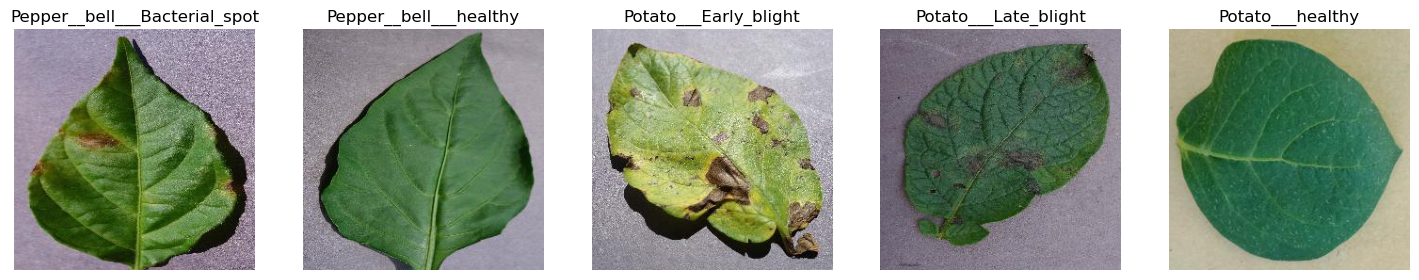

In [ ]:
random_images = []

for class_name in classes:
  choice = random.choice(os.listdir(dir + "/" + class_name))
  random_images.append(f"{dir}/{class_name}/{choice}")

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for i, path in enumerate(random_images):
    # Load and display the image
    img = plt.imread(path)
    axes[i].imshow(img)
    axes[i].set_title(classes[i])
    axes[i].axis('off')

plt.show()

## Data Preprocessing

In [ ]:
directory = "/content/drive/MyDrive/PlantVillage_Dataset/split"
img_data_generator = ImageDataGenerator(rescale=1./225)

# Define batch size
batch_size = 32

# Set up the image generators using flow_from_directory
train_generator = img_data_generator.flow_from_directory(
    split_dir + '/train',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = img_data_generator.flow_from_directory(
    split_dir + '/val',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = img_data_generator.flow_from_directory(
    split_dir + '/test',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical')

Found 4861 images belonging to 5 classes.
Found 917 images belonging to 5 classes.
Found 1360 images belonging to 5 classes.


# Verify that all images are valid

In [ ]:
# Iterate through each folder
for folder in os.listdir(split_dir + "/train"):
    # Get a list of all image files in the folder
    image_files = os.listdir(split_dir + "/train/" + folder)

    # Iterate through each image file
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(split_dir + "/train/" + folder, image_file)

        # Try to open the image using PIL
        try:
            image = Image.open(image_path)
        except Exception as e:
            os.remove(image_path)
            print(f"Error opening image '{image_path}': {e}")

Error opening image '/content/drive/MyDrive/PlantVillage_Dataset/split/train/Pepper__bell___Bacterial_spot/cef63924-0e7e-4df3-9b8c-bdc80f3215f2___JR_B.Spot 3376.JPG': cannot identify image file '/content/drive/MyDrive/PlantVillage_Dataset/split/train/Pepper__bell___Bacterial_spot/cef63924-0e7e-4df3-9b8c-bdc80f3215f2___JR_B.Spot 3376.JPG'


KeyboardInterrupt: 

## Model Building

In [ ]:
def create_model(input_shape):
  model = tf.keras.models.Sequential([
      tf.keras.Input(shape=input_shape), #
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='ReLU'),
      tf.keras.layers.Dense(64, activation='ReLU'),
      tf.keras.layers.Dense(32, activation='ReLU'),
      tf.keras.layers.Dense(32, activation='ReLU'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

def save_model(model_name):
  model.save(f'{models_dir}/{model_name}.keras')

def load_model(model_name):
  return tf.keras.models.load_model(f'{models_dir}/{model_name}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 6303141 (24.04 MB)
Trainable params: 63031

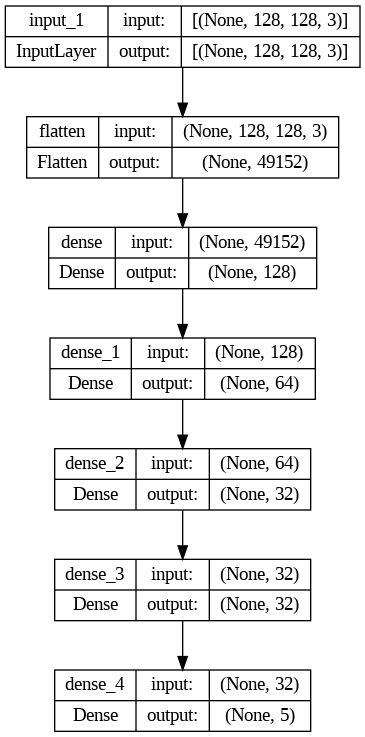

In [ ]:
input_shape = IMG_SIZE + (3,)

model = create_model(input_shape)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

## Model Training

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE)

history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[stop_early, checkpoint])

Epoch 1/100
152/152 [==============================] - ETA: 0s - loss: 1.3470 - accuracy: 0.4340

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 12s 75ms/step - loss: 1.3470 - accuracy: 0.4340 - val_loss: 1.0919 - val_accuracy: 0.5943
Epoch 2/100
152/152 [==============================] - ETA: 0s - loss: 1.0101 - accuracy: 0.6278

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 1.0101 - accuracy: 0.6278 - val_loss: 0.9428 - val_accuracy: 0.6499
Epoch 3/100
152/152 [==============================] - ETA: 0s - loss: 0.8943 - accuracy: 0.6667

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 0.8943 - accuracy: 0.6667 - val_loss: 0.8376 - val_accuracy: 0.6848
Epoch 4/100
152/152 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7091

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.7967 - accuracy: 0.7091 - val_loss: 0.7974 - val_accuracy: 0.7088
Epoch 5/100
152/152 [==============================] - 10s 66ms/step - loss: 0.7552 - accuracy: 0.7263 - val_loss: 0.8068 - val_accuracy: 0.6979
Epoch 6/100
152/152 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.7566

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 0.6947 - accuracy: 0.7566 - val_loss: 0.7157 - val_accuracy: 0.7470
Epoch 7/100
152/152 [==============================] - 10s 65ms/step - loss: 0.6604 - accuracy: 0.7702 - val_loss: 0.7288 - val_accuracy: 0.7535
Epoch 8/100
152/152 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.7763

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 10s 68ms/step - loss: 0.6378 - accuracy: 0.7763 - val_loss: 0.6565 - val_accuracy: 0.7634
Epoch 9/100
152/152 [==============================] - ETA: 0s - loss: 0.5983 - accuracy: 0.7918

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.5983 - accuracy: 0.7918 - val_loss: 0.6237 - val_accuracy: 0.7950
Epoch 10/100
152/152 [==============================] - 10s 67ms/step - loss: 0.6170 - accuracy: 0.7868 - val_loss: 0.6880 - val_accuracy: 0.7634
Epoch 11/100
152/152 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.8082

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 73ms/step - loss: 0.5440 - accuracy: 0.8082 - val_loss: 0.5656 - val_accuracy: 0.7939
Epoch 12/100
152/152 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.8195

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 75ms/step - loss: 0.5292 - accuracy: 0.8195 - val_loss: 0.5425 - val_accuracy: 0.8103
Epoch 13/100
152/152 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8226

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.5155 - accuracy: 0.8226 - val_loss: 0.5332 - val_accuracy: 0.8179
Epoch 14/100
152/152 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.8457

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 69ms/step - loss: 0.4689 - accuracy: 0.8457 - val_loss: 0.5127 - val_accuracy: 0.8201
Epoch 15/100
152/152 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.8438

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 74ms/step - loss: 0.4586 - accuracy: 0.8438 - val_loss: 0.4978 - val_accuracy: 0.8233
Epoch 16/100
152/152 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.8418

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 73ms/step - loss: 0.4515 - accuracy: 0.8418 - val_loss: 0.4667 - val_accuracy: 0.8386
Epoch 17/100
152/152 [==============================] - 10s 65ms/step - loss: 0.4143 - accuracy: 0.8553 - val_loss: 0.4883 - val_accuracy: 0.8266
Epoch 18/100
152/152 [==============================] - 10s 65ms/step - loss: 0.4195 - accuracy: 0.8543 - val_loss: 0.5285 - val_accuracy: 0.8015
Epoch 19/100
152/152 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8753

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 0.3702 - accuracy: 0.8753 - val_loss: 0.4656 - val_accuracy: 0.8266
Epoch 20/100
152/152 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8792

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 69ms/step - loss: 0.3558 - accuracy: 0.8792 - val_loss: 0.4473 - val_accuracy: 0.8495
Epoch 21/100
152/152 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8733

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.3662 - accuracy: 0.8733 - val_loss: 0.3724 - val_accuracy: 0.8637
Epoch 22/100
152/152 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8846

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.3409 - accuracy: 0.8846 - val_loss: 0.3665 - val_accuracy: 0.8800
Epoch 23/100
152/152 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8994

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 0.3019 - accuracy: 0.8994 - val_loss: 0.3320 - val_accuracy: 0.8953
Epoch 24/100
152/152 [==============================] - 10s 64ms/step - loss: 0.3395 - accuracy: 0.8823 - val_loss: 0.3443 - val_accuracy: 0.8790
Epoch 25/100
152/152 [==============================] - 10s 64ms/step - loss: 0.2736 - accuracy: 0.9093 - val_loss: 0.5987 - val_accuracy: 0.7841
Epoch 26/100
152/152 [==============================] - 10s 64ms/step - loss: 0.3128 - accuracy: 0.8930 - val_loss: 0.4348 - val_accuracy: 0.8462
Epoch 27/100
152/152 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9228

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 10s 69ms/step - loss: 0.2395 - accuracy: 0.9228 - val_loss: 0.2910 - val_accuracy: 0.9084
Epoch 28/100
152/152 [==============================] - 10s 64ms/step - loss: 0.2241 - accuracy: 0.9292 - val_loss: 0.4666 - val_accuracy: 0.8353
Epoch 29/100
152/152 [==============================] - 10s 64ms/step - loss: 0.2039 - accuracy: 0.9401 - val_loss: 0.3759 - val_accuracy: 0.8604
Epoch 30/100
152/152 [==============================] - 10s 64ms/step - loss: 0.2238 - accuracy: 0.9302 - val_loss: 0.3268 - val_accuracy: 0.8844
Epoch 31/100
152/152 [==============================] - 10s 63ms/step - loss: 0.2084 - accuracy: 0.9319 - val_loss: 0.3220 - val_accuracy: 0.8877
Epoch 32/100
152/152 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9455

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 69ms/step - loss: 0.1843 - accuracy: 0.9455 - val_loss: 0.2739 - val_accuracy: 0.8997
Epoch 33/100
152/152 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9533

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 0.1642 - accuracy: 0.9533 - val_loss: 0.2455 - val_accuracy: 0.9258
Epoch 34/100
152/152 [==============================] - 10s 64ms/step - loss: 0.1594 - accuracy: 0.9486 - val_loss: 0.2522 - val_accuracy: 0.9106
Epoch 35/100
152/152 [==============================] - 10s 64ms/step - loss: 0.1651 - accuracy: 0.9525 - val_loss: 0.3179 - val_accuracy: 0.8920
Epoch 36/100
152/152 [==============================] - 10s 66ms/step - loss: 0.1190 - accuracy: 0.9720 - val_loss: 0.3002 - val_accuracy: 0.9051
Epoch 37/100
152/152 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9658

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.1288 - accuracy: 0.9658 - val_loss: 0.2369 - val_accuracy: 0.9204
Epoch 38/100
152/152 [==============================] - 10s 66ms/step - loss: 0.1214 - accuracy: 0.9689 - val_loss: 0.2442 - val_accuracy: 0.9215
Epoch 39/100
152/152 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9685

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.1193 - accuracy: 0.9685 - val_loss: 0.1952 - val_accuracy: 0.9368
Epoch 40/100
152/152 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9735

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 72ms/step - loss: 0.1052 - accuracy: 0.9735 - val_loss: 0.1886 - val_accuracy: 0.9433
Epoch 41/100
152/152 [==============================] - 10s 65ms/step - loss: 0.0970 - accuracy: 0.9767 - val_loss: 0.1951 - val_accuracy: 0.9346
Epoch 42/100
152/152 [==============================] - 10s 65ms/step - loss: 0.1027 - accuracy: 0.9706 - val_loss: 0.2962 - val_accuracy: 0.9073
Epoch 43/100
152/152 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9765

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 71ms/step - loss: 0.0963 - accuracy: 0.9765 - val_loss: 0.1614 - val_accuracy: 0.9542
Epoch 44/100
152/152 [==============================] - 10s 66ms/step - loss: 0.0733 - accuracy: 0.9862 - val_loss: 0.1665 - val_accuracy: 0.9466
Epoch 45/100
152/152 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9782

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 70ms/step - loss: 0.0833 - accuracy: 0.9782 - val_loss: 0.1592 - val_accuracy: 0.9509
Epoch 46/100
152/152 [==============================] - 10s 64ms/step - loss: 0.0708 - accuracy: 0.9856 - val_loss: 0.1907 - val_accuracy: 0.9389
Epoch 47/100
152/152 [==============================] - 10s 64ms/step - loss: 0.0738 - accuracy: 0.9813 - val_loss: 0.2416 - val_accuracy: 0.9204
Epoch 48/100
152/152 [==============================] - 10s 64ms/step - loss: 0.0633 - accuracy: 0.9864 - val_loss: 0.1919 - val_accuracy: 0.9368
Epoch 49/100
152/152 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9840

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


152/152 [==============================] - 11s 69ms/step - loss: 0.0643 - accuracy: 0.9840 - val_loss: 0.1465 - val_accuracy: 0.9509
Epoch 50/100
152/152 [==============================] - 10s 66ms/step - loss: 0.0457 - accuracy: 0.9924 - val_loss: 0.1541 - val_accuracy: 0.9487
Epoch 51/100
152/152 [==============================] - 10s 65ms/step - loss: 0.0371 - accuracy: 0.9965 - val_loss: 0.1536 - val_accuracy: 0.9498
Epoch 52/100
152/152 [==============================] - 10s 64ms/step - loss: 0.1260 - accuracy: 0.9644 - val_loss: 0.1497 - val_accuracy: 0.9520
Epoch 53/100
152/152 [==============================] - 10s 64ms/step - loss: 0.0633 - accuracy: 0.9819 - val_loss: 0.1580 - val_accuracy: 0.9477
Epoch 54/100
152/152 [==============================] - 10s 66ms/step - loss: 0.0518 - accuracy: 0.9883 - val_loss: 0.1960 - val_accuracy: 0.9389


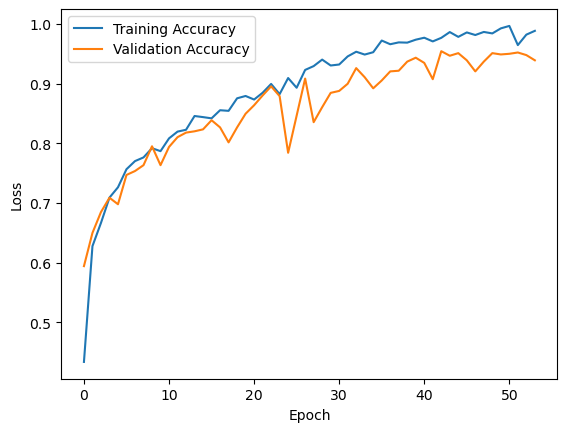

In [ ]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

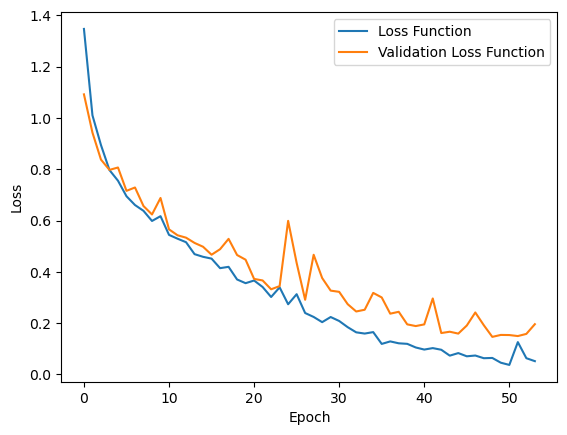

In [ ]:
# Plot the accuracy over epochs
plt.plot(history.history['loss'], label='Loss Function')
plt.plot(history.history['val_loss'], label='Validation Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.locator_params(axis="x", integer=True, tight=True)
plt.show()

## Saving and Loading Model

In [ ]:
save_model("best_model_50EPCH")

In [ ]:
models = []
print("enter model number: ")
for i, model in enumerate(os.listdir(models_dir)):
  print(f'{i} {model}')
  models.append(model)

model = load_model(f'{models[int(input())]}')

## Model Evaluation

### Evaluate Model

### Confusion Matrix

In [1]:

print("test loss, test acc:", model.evaluate(test_generator))

# Get predictions from the model using the test generator
predictions = model.predict_generator(test_generator)

# Get true labels from the test generator
true_labels = test_generator.classes

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:", classification_report(true_labels, predicted_labels))

print("Confusion Matrix:")

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'model' is not defined

## Explaining model outputs with SHAP values

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for _, label in enumerate(os.listdir(split_dir + "/train")):
  for _, file in enumerate(os.listdir(split_dir + "/train/" + label)):
    image = Image.open(split_dir + "/train/" + label + "/" + file)
    image = image.resize(IMG_SIZE)
    image = image.convert('RGB')
    image_array = np.array(image)
    x_train.append(image_array)
    y_train.append(classes.index(label))

for _, label in enumerate(os.listdir(split_dir + "/test")):
  for _, file in enumerate(os.listdir(split_dir + "/test/" + label)):
    image = Image.open(split_dir + "/test/" + label + "/" + file)
    image = image.resize(IMG_SIZE)
    image = image.convert('RGB')
    image_array = np.array(image)
    x_test.append(image_array)
    y_test.append(classes.index(label))

# save as DataX or any other name. But the same element name is to be used while loading it back.
np.savez("/content/drive/MyDrive/PlantVillage_Dataset/mnistlikedataset.npz",x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [ ]:
path = "/content/drive/MyDrive/PlantVillage_Dataset/mnistlikedataset.npz"
x_train, y_train, x_test, y_test
with np.load(path) as data:
    #load DataX as train_data
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

print(x_train.shape)

(4861, 128, 128, 3)


In [ ]:
num_classes = len(CLASSES)
input_shape = IMG_SIZE + (3,)

In [ ]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
# test_df = tf.keras.utils.to_categorical(test_df, num_classes)

x_train shape: (4861, 128, 128, 3)
4861 train samples
1360 test samples


### Initialize SHAP Explainer

In [ ]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on three images
explainer  = shap.DeepExplainer(model, background)

(128, 128, 3)


### Compute SHAP Values

In [ ]:
shap_values = explainer.shap_values(x_test[0:5])

shap_values_combined = np.sum(shap_values[1], axis=-1)  # Combine SHAP values across color channels
abs_max = np.percentile(np.abs(shap_values_combined), 100)
# Normalize the SHAP values to the range [0, 1]
shap_values_normalized = (shap_values_combined - shap_values_combined.min()) / (shap_values_combined.max() - shap_values_combined.min())

### Plot SHAP Values

In [2]:
# Visualize SHAP values for each color channel separately
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(x_test[1])
axes[0].set_title(f"Original Image")
axes[0].axis('off')
for i, channel in enumerate(["Red", "Green", "Blue"]):
    axes[i + 1].imshow(shap_values_normalized[:,:,i], cmap='seismic', vmin=0, vmax=1)
    axes[i + 1].set_title(f"SHAP values for channel {channel}")
    axes[i + 1].axis('off')

plt.show()

NameError: name 'np' is not defined